# Python-code for Diagnosing Parkinson's Disease through Patient Voice Analysis using Machine Learning Models.

This is the code for the paper entitled "Um estudo sobre o uso de modelos de Machine Learning para o diagnóstico da Doença de Parkinson por meio da análise de voz de pacientes" accepted in Proceedings of the XIV Biomedical Engineering Symposium (ISSN: 2358-3568).

If you find this repository useful in your research, please cite:

D. H. da. Silva, C. T. Ribeiroe A. A. Pereira, “Um estudo sobre o uso de modelos de Machine Learning para o diagnóstico da Doença de Parkinson por meio da análise de voz de pacientes”, dez. 2022. https://doi.org/10.5281/zenodo.7490097

## Installing and importing the necesary packages

In [2]:
## Installing
!pip install pandas numpy matplotlib seaborn scikit-learn

## Importing necessary packages
# Windows: python.exe -m pip install sklearn
# macOS terminal: python3 -m pip install sklearn
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Preprocessing
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split, KFold, cross_val_score

## Initializing classification algorithms
from sklearn.neighbors import KNeighborsClassifier #KNN
from sklearn.linear_model import LogisticRegression #LR
from sklearn.naive_bayes import GaussianNB #NB
from sklearn.ensemble import RandomForestClassifier #RF
from sklearn.svm import SVC #SVM

##Metrics
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

## Warning
import warnings
warnings.filterwarnings('ignore')

## Loading the Dataset

The Parkinson dataset used in the paper is publicly available at the UCI Machine Learning Repository at the [link](https://archive.ics.uci.edu/dataset/489/parkinson+dataset+with+replicated+acoustic+features) and contains acoustic features extracted from 3 voice recordings of the sustained /a/ phonation for each of the 80 subjects (40 of them with Parkinson's Disease).


In [3]:
# Loading the dataset with 240 records and 48 variables
df = pd.read_csv('dataset/ParkinsonDatabase.csv')
df.shape

(240, 48)

In [4]:
# Analyzing the first 4 rows of the dataset
df.head(4)
# Observing the data types of the variables
# df.dtypes

,ID,Recording,Status,Gender,Jitter_rel,Jitter_abs,Jitter_RAP,Jitter_PPQ,Shim_loc,Shim_dB,...,Delta3,Delta4,Delta5,Delta6,Delta7,Delta8,Delta9,Delta10,Delta11,Delta12
0,CONT-01,1,0,1,0.25546,0.000015,0.001467,0.001673,0.030256,0.26313,...,1.407701,1.417218,1.380352,1.420670,1.451240,1.440295,1.403678,1.405495,1.416705,1.354610
1,CONT-01,2,0,1,0.36964,0.000022,0.001932,0.002245,0.023146,0.20217,...,1.331232,1.227338,1.213377,1.352739,1.354242,1.365692,1.322870,1.314549,1.318999,1.323508
2,CONT-01,3,0,1,0.23514,0.000013,0.001353,0.001546,0.019338,0.16710,...,1.412304,1.324674,1.276088,1.429634,1.455996,1.368882,1.438053,1.388910,1.305469,1.305402
3,CONT-02,1,0,0,0.29320,0.000017,0.001105,0.001444,0.024716,0.20892,...,1.501200,1.534170,1.323993,1.496442,1.472926,1.643177,1.551286,1.638346,1.604008,1.621456


## Preprocessing and Standardization

In [5]:
## Variable Names
nomeColunas = df.columns
nomeColunas

Index(['ID', 'Recording', 'Status', 'Gender', 'Jitter_rel', 'Jitter_abs',
       'Jitter_RAP', 'Jitter_PPQ', 'Shim_loc', 'Shim_dB', 'Shim_APQ3',
       'Shim_APQ5', 'Shim_APQ11', 'HNR05', 'HNR15', 'HNR25', 'HNR35', 'HNR38',
       'RPDE', 'DFA', 'PPE', 'GNE', 'MFCC0', 'MFCC1', 'MFCC2', 'MFCC3',
       'MFCC4', 'MFCC5', 'MFCC6', 'MFCC7', 'MFCC8', 'MFCC9', 'MFCC10',
       'MFCC11', 'MFCC12', 'Delta0', 'Delta1', 'Delta2', 'Delta3', 'Delta4',
       'Delta5', 'Delta6', 'Delta7', 'Delta8', 'Delta9', 'Delta10', 'Delta11',
       'Delta12'],
      dtype='object')

In [6]:
## Creating a list with the attributes, separating them from other variables
atributos = nomeColunas[4:]
# Creating a loop for data standardization
contador = 4
for atributo in atributos:
    padronizados = []

    for i in df[atributo]:
        padronizados.append(math.log(i,10))

    padronizados = minmax_scale(padronizados)
    df = df.drop(columns=atributo)
    df.insert(loc=contador, column=atributo, value=padronizados)
    contador += 1

In [7]:
## Creating an empty dataset to store the mean values of each patient's records
nomeAtributos = df.columns[4: ]
dados = pd.DataFrame(columns=nomeAtributos)
dados.head()

,Jitter_rel,Jitter_abs,Jitter_RAP,Jitter_PPQ,Shim_loc,Shim_dB,Shim_APQ3,Shim_APQ5,Shim_APQ11,HNR05,...,Delta3,Delta4,Delta5,Delta6,Delta7,Delta8,Delta9,Delta10,Delta11,Delta12


In [9]:
## Declaring the new variables status and gender to collect their values every 3 records as well as create the DataFrame
status = df['Status'].tolist()
gender = df['Gender'].tolist()

novoStatus = []  # empty list
novoGender = []

for i in range(0, len(status), 3):
    novoStatus.append(status[i])
    novoGender.append(gender[i])
    media = df[nomeAtributos].iloc[[i, i+1, i+2]].mean(axis=0)  # Another option would be to use the median
    dados = pd.concat([dados, media.to_frame().T], ignore_index=True)

In [10]:
## Observing the first 3 records of the new dataset.
dados.head(3)

,Jitter_rel,Jitter_abs,Jitter_RAP,Jitter_PPQ,Shim_loc,Shim_dB,Shim_APQ3,Shim_APQ5,Shim_APQ11,HNR05,...,Delta3,Delta4,Delta5,Delta6,Delta7,Delta8,Delta9,Delta10,Delta11,Delta12
0,0.167313,0.188417,0.200556,0.133088,0.357736,0.352159,0.398112,0.387301,0.310350,0.642315,...,0.665718,0.510483,0.628141,0.635890,0.690788,0.650952,0.613847,0.615713,0.675877,0.605082
1,0.107455,0.150592,0.090730,0.062494,0.217872,0.215143,0.248739,0.252244,0.202908,0.725295,...,0.754630,0.660136,0.747662,0.791970,0.710295,0.753832,0.780908,0.789895,0.780707,0.715060
2,0.113051,0.166572,0.166969,0.095198,0.276710,0.274003,0.305235,0.316930,0.257402,0.787118,...,0.844668,0.646489,0.781302,0.620814,0.762391,0.666213,0.655040,0.766339,0.883611,0.752251


In [11]:
## Inserting the variables Gender and Status into the Dataset
dados.insert(0, 'Gender', novoGender)
dados.insert(0, 'Status', novoStatus)
# Observing the first 7 records of the Dataset
dados.head(7)

,Status,Gender,Jitter_rel,Jitter_abs,Jitter_RAP,Jitter_PPQ,Shim_loc,Shim_dB,Shim_APQ3,Shim_APQ5,...,Delta3,Delta4,Delta5,Delta6,Delta7,Delta8,Delta9,Delta10,Delta11,Delta12
0,0,1,0.167313,0.188417,0.200556,0.133088,0.357736,0.352159,0.398112,0.387301,...,0.665718,0.510483,0.628141,0.635890,0.690788,0.650952,0.613847,0.615713,0.675877,0.605082
1,0,0,0.107455,0.150592,0.090730,0.062494,0.217872,0.215143,0.248739,0.252244,...,0.754630,0.660136,0.747662,0.791970,0.710295,0.753832,0.780908,0.789895,0.780707,0.715060
2,0,1,0.113051,0.166572,0.166969,0.095198,0.276710,0.274003,0.305235,0.316930,...,0.844668,0.646489,0.781302,0.620814,0.762391,0.666213,0.655040,0.766339,0.883611,0.752251
3,0,1,0.530916,0.580286,0.553443,0.430681,0.379989,0.378006,0.416113,0.372117,...,0.768217,0.611319,0.826046,0.683721,0.813216,0.707039,0.800814,0.608143,0.844810,0.788565
4,0,0,0.359656,0.547033,0.343497,0.298568,0.480625,0.472485,0.494463,0.496986,...,0.673844,0.643307,0.902141,0.749905,0.923264,0.657936,0.675329,0.618058,0.721695,0.762546
5,0,1,0.291063,0.336965,0.323384,0.241492,0.383459,0.377171,0.421476,0.409746,...,0.703088,0.583173,0.743789,0.532694,0.764949,0.569778,0.662128,0.613788,0.718150,0.672893
6,0,0,0.336539,0.443115,0.342664,0.280001,0.567571,0.561300,0.583487,0.593960,...,0.735636,0.680964,0.734013,0.769594,0.706692,0.799334,0.686373,0.769432,0.852655,0.746786


In [12]:
# Creating a copy of the Dataset
dados_finais = dados
dados_finais.shape

(80, 46)

## Splitting the data

In [13]:
## Splitting data into training and testing sets
df_valor = dados_finais.values
target = df_valor[: , 0].astype(int)
atributos = np.delete(df_valor, 0, 1)

x_treino, x_teste, y_treino, y_teste = train_test_split(atributos,
                                            target, test_size = 0.33, random_state=1245)

In [14]:
## Observing the dimensions of training and testing data
x_treino.shape
y_teste.shape

(27,)

## Training the models and selecting the best ones

#### Training the models

In [17]:
## Training models and selecting the top three based on accuracy
# Metric defined to be used for selecting the 3 best model
# options: 'f1_macro', 'precision_macro', 'recall_macro', 'accuracy'
metrica = 'accuracy'

# List of model names for training
nomes_modelos = ["Nearest Neighbors",
                    "Logistic Regression",
                    "Naive Bayes",
                    "Random Forest",
                    "SVM Linear",
                    "SVM Sigmoid"]

# Now create the classifiers based on the chosen models.
# Mentioned in the article.
classificadores = [
    KNeighborsClassifier(n_neighbors = 5),
    LogisticRegression(multi_class = 'multinomial', random_state = 1245),
    GaussianNB(),
    RandomForestClassifier(random_state = 1245),
    SVC(kernel = 'linear'),
    SVC(kernel = 'sigmoid')
]

In [18]:
## Creating an training the models
# Lists to record the results
resultados = []
nomes = []
# Combining model names and classifiers into a single object for iterations
modelos = zip(nomes_modelos, classificadores)
# Applying cross-validation to train all models
for nome, modelo in modelos:
    nfold = 6
    cv_results = cross_val_score(modelo, x_treino, y_treino, cv = nfold, scoring = metrica)
    resultados.append(cv_results)
    nomes.append(nome)
    msg = "%s: %.2f (%.2f)" % (nome, cv_results.mean()*100, cv_results.std()*100)
    print(msg)

Nearest Neighbors: 81.25 (8.09)
Logistic Regression: 83.10 (10.53)
Naive Bayes: 83.10 (10.53)
Random Forest: 77.31 (11.16)
SVM Linear: 83.33 (10.64)
SVM Sigmoid: 54.63 (2.07)


>  Analyzing the results above, we observe that the Linear SVM, Naive Bayes, and Logistic Regression algorithms showed the best performance.


### Top 3 models analysis

#### Creating: Naive Bayes, SVM-Linear and LR

In [19]:
## Creating the models with the best accuracy
# Gaussian Naive Bayes Model (NB)
modeloNB = GaussianNB()
# Support Vector Machine Model (SVM - Linear)
modeloSVMLinear =  SVC(kernel = 'linear', probability=True)
# Logistic Regression Model (LR)
modeloLR =  LogisticRegression()

####  Confusion Matrix and Metrics for each model.

In [20]:
## GaussianNB ##
# Making predictions, and generating the confusion matrix
previsao = modeloNB.fit(x_treino, y_treino)
previsoesNB = previsao.predict(x_teste)
cm = metrics.confusion_matrix(y_teste,previsoesNB)
print("\nMatriz de Confusão")
print(cm)
# Generating important metrics such as: Accuracy, Precision, and Recall
print("\nAcurácia: ", metrics.accuracy_score(y_teste,previsoesNB)*100)
print("\nPrecisão: ", metrics.precision_score(y_teste,previsoesNB)*100)
print("\nRecall: ", metrics.recall_score(y_teste,previsoesNB)*100)
print("\nF1-Score: ", metrics.f1_score(y_teste,previsoesNB)*100)


Matriz de Confusão
[[11  0]
 [ 2 14]]

Acurácia:  92.5925925925926

Precisão:  100.0

Recall:  87.5

F1-Score:  93.33333333333333


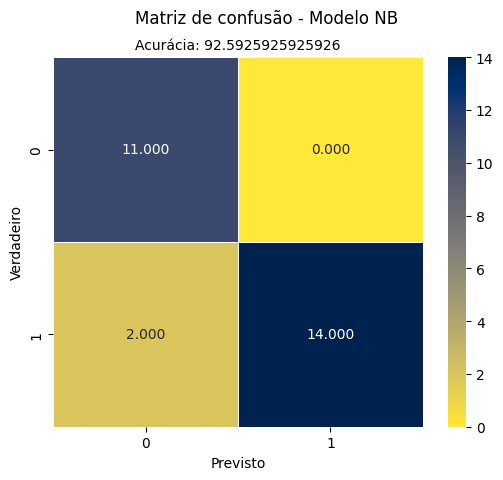

In [21]:
## Confusion Matrix using Seaborn
sns.heatmap(metrics.confusion_matrix(y_teste,previsoesNB),
annot=True,
fmt = ".3f",
linewidths=0.5,
square = True,
cmap = 'cividis_r')

plt.ylabel('Verdadeiro')
plt.xlabel('Previsto')
titulo = metrics.accuracy_score(y_teste, previsoesNB)
plt.suptitle('Matriz de confusão - Modelo NB', size = 12)
plt.title('Acurácia: {0}'.format(titulo*100), size=10)
plt.savefig('matrixConfusaoNB.eps', format = 'eps', dpi = 300)

In [22]:
## SVM-LINEAR ##
# Making predictions, and generating the confusion matrix
previsaoSVM = modeloSVMLinear.fit(x_treino, y_treino)
previsoesSVM = previsaoSVM.predict(x_teste)
cmSVM = metrics.confusion_matrix(y_teste,previsoesSVM)
print("\nMatriz de Confusão")
print(cmSVM)
# Generating important metrics such as: Accuracy, Precision, and Recall
print("\nAcurácia: ", metrics.accuracy_score(y_teste,previsoesSVM))
print("\nPrecisão: ", metrics.precision_score(y_teste,previsoesSVM))
print("\nRecall: ", metrics.recall_score(y_teste,previsoesSVM))
print("\nF1-Score: ", metrics.f1_score(y_teste,previsoesSVM))


Matriz de Confusão
[[11  0]
 [ 3 13]]

Acurácia:  0.8888888888888888

Precisão:  1.0

Recall:  0.8125

F1-Score:  0.896551724137931


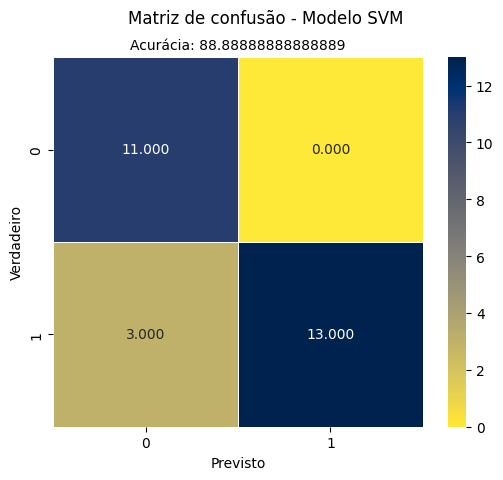

In [23]:
## Confusion Matrix using Seaborn
sns.heatmap(metrics.confusion_matrix(y_teste,previsoesSVM),
annot=True,
fmt = ".3f",
linewidths=0.5,
square = True,
cmap = 'cividis_r')

plt.ylabel('Verdadeiro')
plt.xlabel('Previsto')
titulo = metrics.accuracy_score(y_teste, previsoesSVM)
plt.suptitle('Matriz de confusão - Modelo SVM', size = 12)
plt.title('Acurácia: {0}'.format(titulo*100), size=10)
plt.savefig('matrixConfusaoSVM.eps', format = 'eps', dpi = 300)

In [24]:
## SVM-LINEAR ##
# Making predictions, and generating the confusion matrix
previsoesLR = modeloLR.fit(x_treino, y_treino).predict(x_teste)
cmLR = metrics.confusion_matrix(y_teste,previsoesLR)
print("\nMatriz de Confusão")
print(cmLR)
# Generating important metrics such as: Accuracy, Precision, and Recall
print("\nAcurácia: ", metrics.accuracy_score(y_teste, previsoesLR))
print("\nPrecisão: ", metrics.precision_score(y_teste, previsoesLR))
print("\nRecall: ", metrics.recall_score(y_teste,previsoesLR ))
print("\nF1-Score: ", metrics.f1_score(y_teste,previsoesLR))


Matriz de Confusão
[[11  0]
 [ 3 13]]

Acurácia:  0.8888888888888888

Precisão:  1.0

Recall:  0.8125

F1-Score:  0.896551724137931


#### ROC Curve for the Top 3 Best-Performing Models

In [25]:
## Predicting the probability for the top 3 models
previsoes_probaNB = modeloNB.predict_proba(x_teste)
previsoes_probaSVM = modeloSVMLinear.predict_proba(x_teste)
previsoes_probaLR = modeloLR.predict_proba(x_teste)
# Predicting the probability of the target variable being 1
previsoes_probaNB = previsoes_probaNB[:, 1]
previsoes_probaSVM = previsoes_probaSVM[:, 1]
previsoes_probaLR = previsoes_probaLR[:, 1]

In [26]:
## Calculating the Area Under the ROC Curve (AUROC)
nb_auc = roc_auc_score(y_teste, previsoes_probaNB)
svm_auc = roc_auc_score(y_teste, previsoes_probaSVM)
lr_auc = roc_auc_score(y_teste,previsoes_probaLR)
# Calculation for the ROC curve
fpr_NB, tpr_NB, thresholds_NB = roc_curve(y_teste, previsoes_probaNB, pos_label = 1, sample_weight = None)
fpr_SVM, tpr_SVM, thresholds_SVM = roc_curve(y_teste, previsoes_probaSVM, pos_label = 1, sample_weight = None)
fpr_LR, tpr_LR, thresholds_LR = roc_curve(y_teste, previsoes_probaLR, pos_label = 1, sample_weight = None)
# Printing the AUROC values
print('Naïve Bayes: AUROC = %.2f' % (nb_auc))
print('Support Vector Machine - Linear: AUROC = %.2f' % (svm_auc))
print('Logistic Regression: AUROC = %.2f' % (lr_auc))

Naïve Bayes: AUROC = 0.88
Support Vector Machine - Linear: AUROC = 0.91
Logistic Regression: AUROC = 0.90


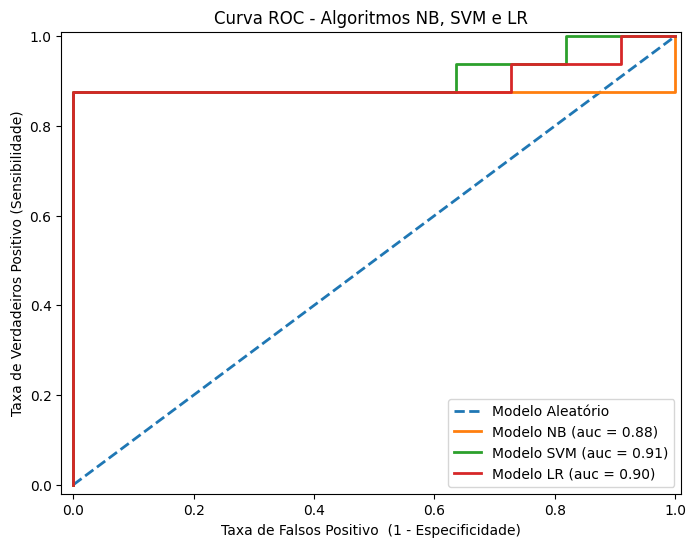

In [27]:
## Plotting the ROC curve graph for the Top 3 Best-Performing Models
plt.figure(figsize = (8,6))
plt.plot([0,1],[0,1], linewidth = 2.0, linestyle= '--', label = "Modelo Aleatório")
plt.plot(fpr_NB, tpr_NB, linewidth = 2.0, label = "Modelo NB (auc = %.2f)" %(nb_auc))
plt.plot(fpr_SVM, tpr_SVM, linewidth = 2.0, label = "Modelo SVM (auc = %.2f)" %(svm_auc))
plt.plot(fpr_LR, tpr_LR, linewidth = 2.0, label = "Modelo LR (auc = %.2f)" %(lr_auc))
# Title
plt.title('Curva ROC - Algoritmos NB, SVM e LR')
# Axes
plt.xlabel('Taxa de Falsos Positivo  (1 - Especificidade)')
plt.ylabel('Taxa de Verdadeiros Positivo (Sensibilidade)')
# Limits
plt.xlim([-0.02,1.01])
plt.ylim([-0.02,1.01])
# Legend
plt.legend(loc="lower right")
# Save the figure
plt.savefig('matrixConfusaoSVM.eps', format = 'eps', dpi = 300)
plt.savefig('ROC_Curve_Final.eps', format = 'eps', dpi = 300)